# INFO about this run

Evaluating a particular saved model

In [1]:
MPATH = "DARTS_NBEATS_v6"+str(200)+"_generic_af_OOS"+"_60-10"+".pth.tar"               # <--- Change this
EPOCHS = 200 #nb
LOOKBACK = 60
FORWARD = 10

In [2]:
MPATH

'DARTS_NBEATS_v6200_generic_af_OOS_60-10.pth.tar'

In [3]:
# False --> Retrain
LOAD = True
# False --> Retrain
SAVE = True
# False --> univar
COVS = False
# False --> Train, val, and OOS, else, just Train and then forecast on OOS
OOS = True

In [4]:
#======Core============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#======PytorchLightning===========
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback
#======Darts===========
from darts.models import NBEATSModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing import Pipeline
from darts.utils.timeseries_generation import datetime_attribute_timeseries
#======UEXP============
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
#from ue.uexp.dataprocessing.ta import *
#from ue.uexp.models.util import *
#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta

import warnings
warnings.filterwarnings('ignore')

import time
from datetime import timedelta
startTime = time.time()

Importing plotly failed. Interactive plots will not work.


# Data Processing

In [5]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2022-02-20"
end_date = "2022-02-21"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-19.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-20.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-21.csv


In [6]:
df.head()

,open,high,low,close,volume,tic
2022-02-20 00:00:00,40079.17,40082.62,40077.30,40082.62,0.13628,BTCUSDT
2022-02-20 00:00:01,40082.62,40087.28,40082.62,40087.28,0.10610,BTCUSDT
2022-02-20 00:00:02,40087.27,40087.28,40087.27,40087.27,0.01677,BTCUSDT
2022-02-20 00:00:03,40087.28,40087.28,40087.27,40087.28,0.00348,BTCUSDT
2022-02-20 00:00:04,40087.28,40087.28,40087.27,40087.28,0.01393,BTCUSDT


In [48]:
df.shape

(172800, 21)

## Indicators

In [7]:
IND_VIEW = 500

### Stochastic RSI

In [8]:
# Stoch RSIs (StochRSI)
indicator_srsi = ta.momentum.StochRSIIndicator(
    close=df["close"], window=14, smooth1=3, smooth2=3, fillna=True
)

# df_covs = pd.concat([indicator_srsi.stochrsi()])

df["momentum_stoch_rsi"] = indicator_srsi.stochrsi()
df["momentum_stoch_rsi_k"] = indicator_srsi.stochrsi_k()
df["momentum_stoch_rsi_d"] = indicator_srsi.stochrsi_d()

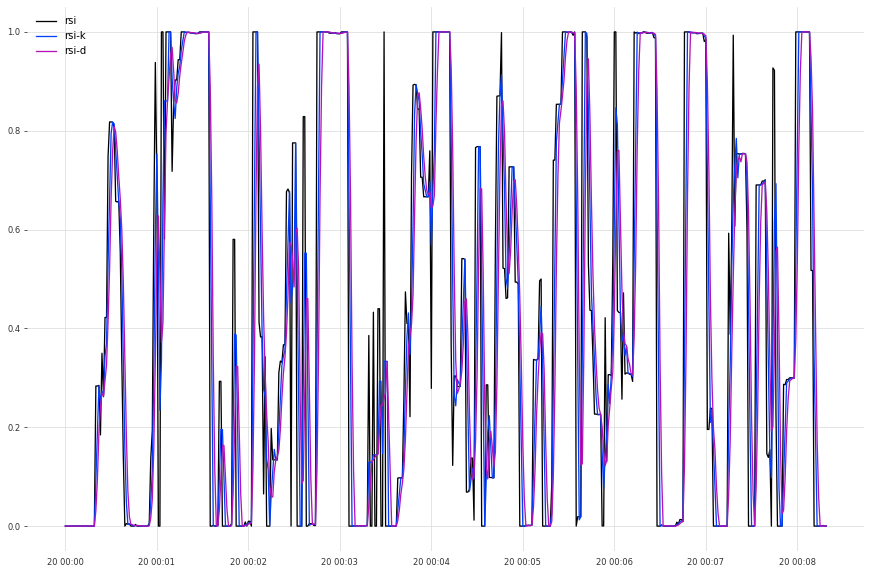

In [9]:
plt.figure(figsize=(15,10))
plt.plot(df["momentum_stoch_rsi"][:IND_VIEW], label="rsi")
plt.plot(df["momentum_stoch_rsi_k"][:IND_VIEW], label="rsi-k")
plt.plot(df["momentum_stoch_rsi_d"][:IND_VIEW], label="rsi-d")
plt.legend()

### MACD

In [10]:
# MACD
indicator_macd = MACD(
    close=df["close"], window_slow=26, window_fast=12, window_sign=9, fillna=True
)
df["trend_macd"] = indicator_macd.macd()
df["trend_macd_signal"] = indicator_macd.macd_signal()
df["trend_macd_diff"] = indicator_macd.macd_diff()

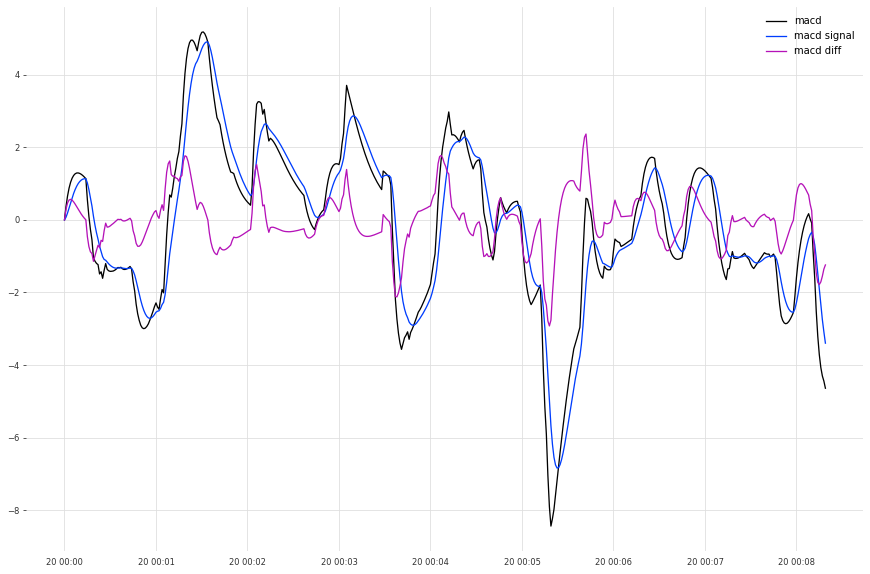

In [11]:
plt.figure(figsize=(15,10))
plt.plot(df["trend_macd"][:IND_VIEW], label="macd")
plt.plot(df["trend_macd_signal"][:IND_VIEW], label="macd signal")
plt.plot(df["trend_macd_diff"][:IND_VIEW], label="macd diff")
plt.legend()

### TSI (momentum)

In [12]:
# TSI Indicator (momentum)
df["momentum_tsi"] = TSIIndicator(
    close=df["close"], window_slow=25, window_fast=13, fillna=True
).tsi()/100 #scale 0-1

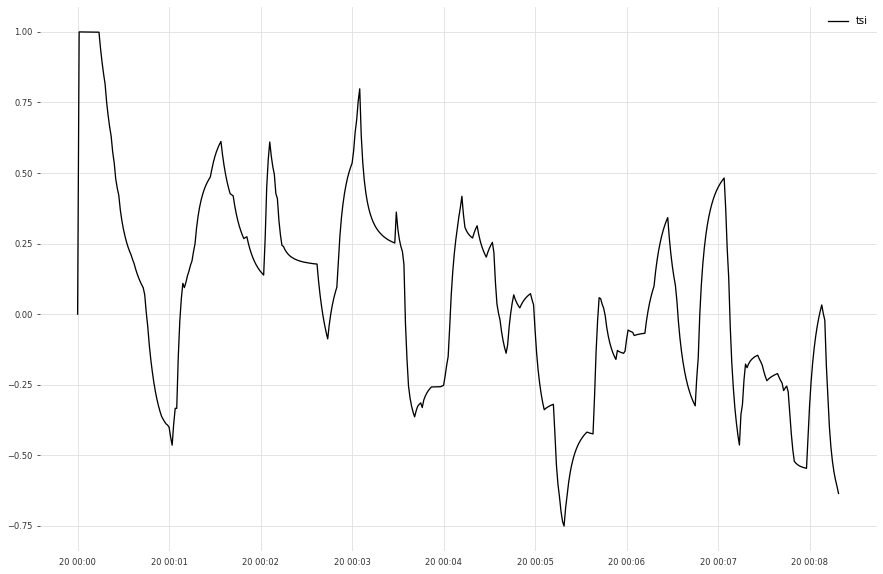

In [13]:
plt.figure(figsize=(15,10))
plt.plot(df["momentum_tsi"][:IND_VIEW], label="tsi")
plt.legend()

### Volume Indicators

In [14]:
# Chaikin Money Flow
df["volume_cmf"] = ChaikinMoneyFlowIndicator(
    high=df["high"], low=df["low"], close=df["close"], volume=df["volume"], fillna=True
).chaikin_money_flow()

# Money Flow Index
df["volume_mfi"] = MFIIndicator(
            high=df["high"], low=df["low"], close=df["close"], volume=df["volume"], fillna=True
        ).money_flow_index()/100 #norm to 0-1

# Force Index
df["volume_fi"] = ForceIndexIndicator(
    close=df["close"], volume=df["volume"], window=13, fillna=True
).force_index() # NOT NORMALIZED

# Volume Weighted Average Price
df["volume_vwap"] = VolumeWeightedAveragePrice(
    high=df["high"], low=df["low"], close=df["close"], volume=df["volume"], fillna=True,
    window=14,
).volume_weighted_average_price()

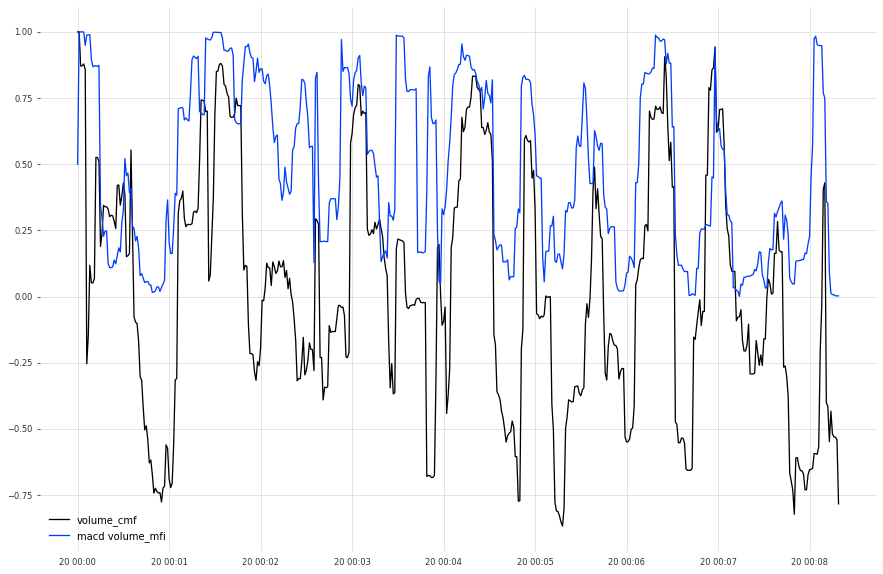

In [15]:
plt.figure(figsize=(15,10))
plt.plot(df["volume_cmf"][:IND_VIEW], label="volume_cmf")
plt.plot(df["volume_mfi"][:IND_VIEW], label="macd volume_mfi")
# plt.plot(df["volume_fi"][:IND_VIEW], label="volume_fi")
# plt.plot(df["volume_vwap"][:IND_VIEW], label="volume_vwap")
plt.legend()

### Force Index

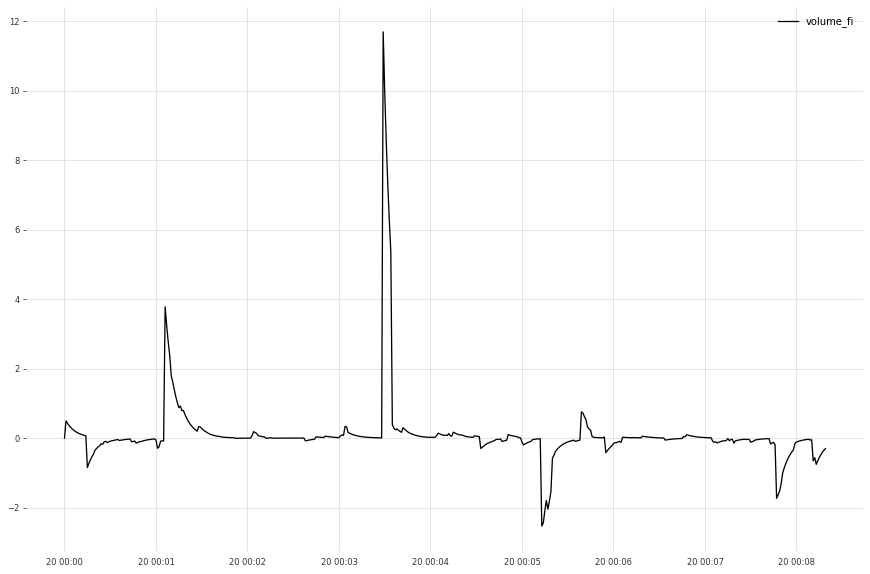

In [16]:
plt.figure(figsize=(15,10))
plt.plot(df["volume_fi"][:IND_VIEW], label="volume_fi")
plt.legend()

### VWAP

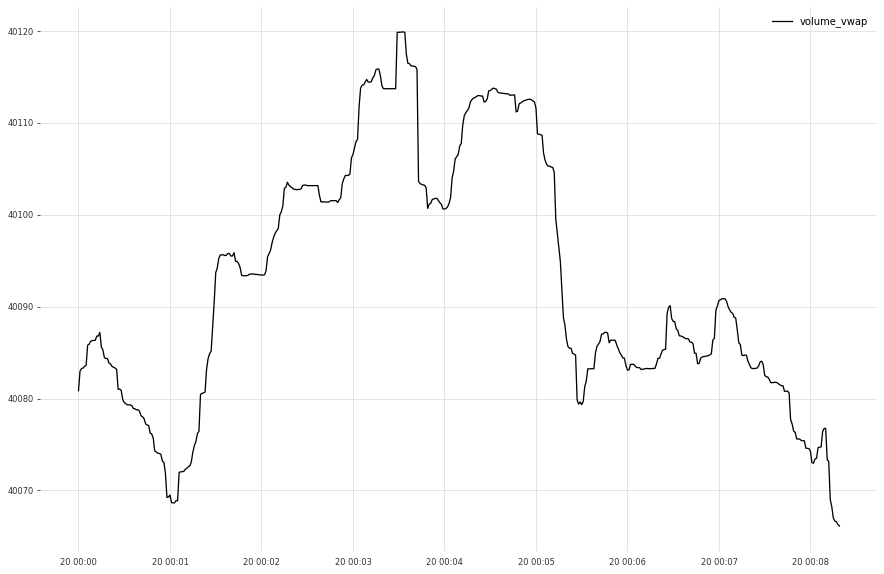

In [17]:
plt.figure(figsize=(15,10))
plt.plot(df["volume_vwap"][:IND_VIEW], label="volume_vwap")
plt.legend()

### SMA, EMA

In [18]:
# SMAs
df["trend_sma_fast"] = SMAIndicator(
    close=df["close"], window=12, fillna=True
).sma_indicator()
df["trend_sma_slow"] = SMAIndicator(
    close=df["close"], window=26, fillna=True
).sma_indicator()

# EMAs
df["trend_ema_fast"] = EMAIndicator(
    close=df["close"], window=12, fillna=True
).ema_indicator()
df["trend_ema_slow"] = EMAIndicator(
    close=df["close"], window=26, fillna=True
).ema_indicator()

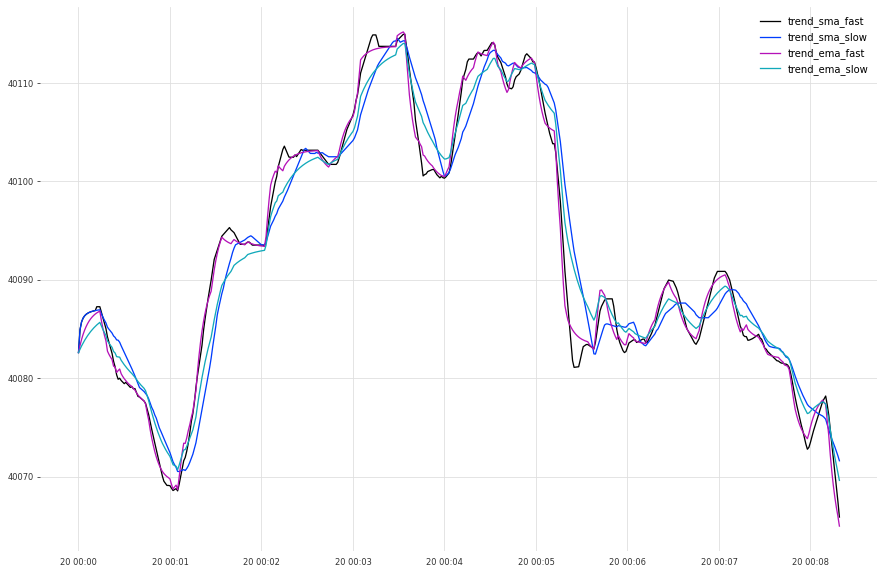

In [19]:
plt.figure(figsize=(15,10))
plt.plot(df["trend_sma_fast"][:IND_VIEW], label="trend_sma_fast")
plt.plot(df["trend_sma_slow"][:IND_VIEW], label="trend_sma_slow")
plt.plot(df["trend_ema_fast"][:IND_VIEW], label="trend_ema_fast")
plt.plot(df["trend_ema_slow"][:IND_VIEW], label="trend_ema_slow")
plt.legend()

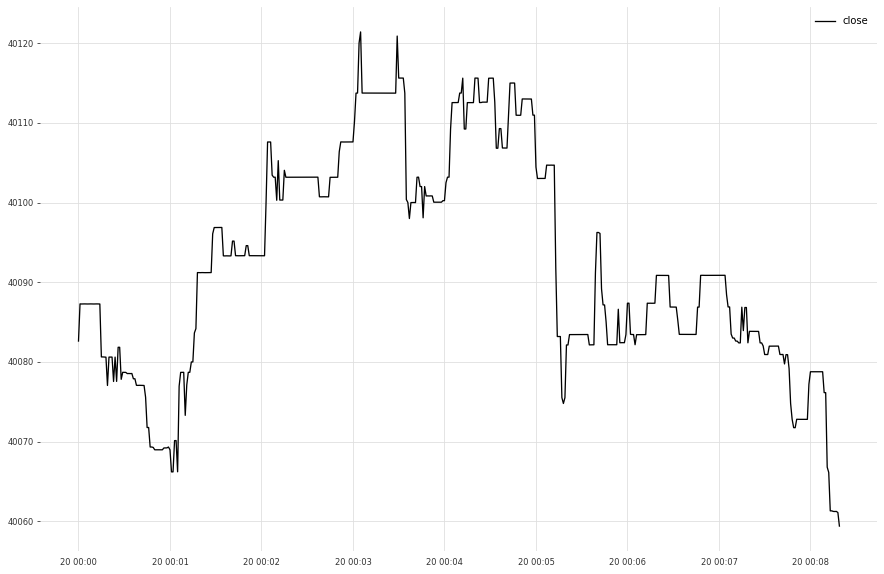

In [20]:
plt.figure(figsize=(15,10))
plt.plot(df["close"][:IND_VIEW], label="close")
plt.legend()

## VERDICT

SMA, EMA not interesting, same with VWAP, ema smoother <br>
Force Index good but need normalizing, <br>
cmf, mfi good (already normalized)<br>
tsi good skip first bit<br>
macd (rough) macd signal (smooth), macd difference  --> (use macd signal and difference need normalizing<br>
sRSIs all the same, just use one <br>

In [21]:
df_covs = df[["volume_fi", "volume_mfi", "volume_cmf", "momentum_tsi", "trend_macd_diff", "trend_macd_signal", "momentum_stoch_rsi"]]
df_covs.describe()

,volume_fi,volume_mfi,volume_cmf,momentum_tsi,trend_macd_diff,trend_macd_signal,momentum_stoch_rsi
count,172800.000000,172800.000000,172800.000000,172800.000000,172800.000000,172800.000000,172800.000000
mean,-0.537938,0.490089,-0.001829,-0.011152,-0.000064,-0.124366,0.488605
std,29.632126,0.304363,0.447692,0.369986,1.822024,5.864800,0.409391
min,-3529.972864,0.000000,-0.996468,-0.996961,-26.166001,-55.963466,0.000000
25%,-0.441846,0.215803,-0.338955,-0.249693,-0.659000,-2.396271,0.004378
50%,-0.001172,0.485236,-0.003137,-0.011287,-0.010821,-0.081606,0.474060
75%,0.378218,0.761662,0.338264,0.230050,0.635271,2.027865,0.988937
max,1136.562912,1.000000,1.000000,1.000000,32.529418,98.660992,1.000000


# SHORTEN SIZE FOR DEBUGGING

In [22]:
# df = df[:2000]

## Main Series

In [23]:
series = df[['close']]
series_ts = TimeSeries.from_dataframe(series)
# optimize
series_ts = series_ts.astype(np.float32)

## Covariate series
- sRSI
- MACD
- PPO (percentage price oscillator)
- Boinglinger whatever

In [24]:
ts_covF = TimeSeries.from_dataframe(df_covs)
ts_covF = ts_covF.astype(np.float32)

## Splitting & Scaling

*NOTE*: validation series must be LOOKBACK+FOWARD+1 in length.

So lets do ((LOOKBACK+FORWARD+1)/len(series_ts) + FORWARD) split percent. Where the first LOOKBACK+FOWARD+1 is the validation set, and the remaining FORWARD is the k out of sample forecast.

<br>

We also need to do a no validation and just out of sample forecast (which is more realistic to what we use it for)

### Time domain features ... ?

In [25]:
covariates = datetime_attribute_timeseries(ts_covF, attribute="minute", one_hot=True)

### tr-val-te

In [26]:
def prep_tr_val_te():
    tr_valte_split = 1- (LOOKBACK+FORWARD+1+FORWARD)/len(series_ts)

    series_scaler = Scaler()
    cov_scaler = Scaler()

    series_ts_tr, series_ts_valte = series_ts.split_after(tr_valte_split)
    p_cov_ts_tr, p_cov_ts_valte = ts_covF.split_after(tr_valte_split)

    val_te_split = 1 - (FORWARD/len(series_ts_valte))

    #split valte -> val, test: Each has FORWARD number of points
    series_ts_val, series_ts_te = series_ts_valte.split_after(val_te_split)
    p_cov_ts_val, p_cov_ts_te = p_cov_ts_valte.split_after(val_te_split) 

    series_ts_tr_scaled = series_scaler.fit_transform(series_ts_tr) 
    p_cov_ts_tr_scaled = cov_scaler.fit_transform(p_cov_ts_tr)

    series_ts_val_scaled = series_scaler.transform(series_ts_val)
    p_cov_ts_val_scaled = cov_scaler.transform(p_cov_ts_val)

    series_ts_te_scaled = series_scaler.transform(series_ts_te)
    p_cov_ts_te_scaled = cov_scaler.transform(p_cov_ts_te)
    
    assert len(series_ts_val) == LOOKBACK+FORWARD+1
    assert len(series_ts_te) == FORWARD
    
    return series_ts_tr, series_ts_val, series_ts_te, series_ts_tr_scaled, p_cov_ts_tr_scaled, series_ts_val_scaled, p_cov_ts_val_scaled, series_ts_te_scaled, p_cov_ts_te_scaled, series_scaler, cov_scaler

In [27]:
series_ts_tr, series_ts_val, series_ts_te, series_ts_tr_scaled, p_cov_ts_tr_scaled, series_ts_val_scaled, p_cov_ts_val_scaled, series_ts_te_scaled, p_cov_ts_te_scaled, series_scaler, cov_scaler = prep_tr_val_te()

In [28]:
len(series_ts_tr_scaled)

172719

### Only FORWARD out of sample

In [29]:
def prep_oos():
    tr_oos_split = 1 - (FORWARD)/len(series_ts)

    series_scaler = Scaler()
    cov_scaler = Scaler()

    series_ts_tr, series_ts_oos = series_ts.split_after(tr_oos_split)
    p_cov_ts_tr, p_cov_ts_oos = ts_covF.split_after(tr_oos_split)

    series_ts_tr_scaled = series_scaler.fit_transform(series_ts_tr) 
    p_cov_ts_tr_scaled = cov_scaler.fit_transform(p_cov_ts_tr)

    series_ts_oos_scaled = series_scaler.transform(series_ts_oos)
    p_cov_ts_oos_scaled = cov_scaler.transform(p_cov_ts_oos) #may be incorrect, may need covs to cover some past

    assert len(series_ts_oos_scaled) == FORWARD
    return series_ts_tr, series_ts_oos, series_ts_tr_scaled, p_cov_ts_tr_scaled, series_ts_oos_scaled, p_cov_ts_oos_scaled, series_scaler, cov_scaler

In [30]:
series_ts_tr, series_ts_oos, series_ts_tr_scaled, p_cov_ts_tr_scaled, series_ts_oos_scaled, p_cov_ts_oos_scaled, series_scaler, cov_scaler = prep_oos()

In [31]:
len(series_ts_oos)

10

# Model

In [32]:
class LossLogger(Callback):
    # checkout pl.Callback hooks: https://pytorch-lightning.readthedocs.io/en/stable/extensions/callbacks.html
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.smt = []

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))
        self.smt.append(trainer.callback_metrics)

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))

loss_logger = LossLogger()

In [33]:
model = NBEATSModel.load_model(MPATH)

In [34]:
# training was for horizon=30, if predict here horizon>15 then need historic_future_covs but nbeats doesnt support future Covs atm
# pred_scaled = models['milk_model'].predict(series=series_ts_tr_scaled, n=FORWARD)

if OOS:
    print('forecasting OOS')
    pred_scaled = model.predict(
            series=series_ts_tr_scaled, 
            n=FORWARD)
else:
    if COVS:
        pred_scaled = model.predict(
            series=series_ts_tr_scaled, 
            past_covariates=p_cov_ts_tr_scaled.concatenate(p_cov_ts_val_scaled), # or else not enough either past or future
            n=len(series_ts_val_scaled))
    else:
        pred_scaled = model.predict(
            series=series_ts_tr_scaled, 
            n=len(series_ts_val_scaled))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


forecasting OOS


Predicting: 169it [00:00, ?it/s]

In [35]:
# scale back:
pred = series_scaler.inverse_transform(pred_scaled)

# SAVE MODEL

In [36]:
# if SAVE:
#     models['generic_af'].save_model(EXP_NAME+str(EPOCHS)+"_generic_af_OOS"+"_60-10"+".pth.tar")

# Evaluate Metrics
https://datasciencestunt.com/mean-directional-accuracy-of-time-series-forecast/ <br>
https://en.wikipedia.org/wiki/Forecasting#Forecasting_accuracy

In [37]:
# Mean Directional Accuracy: GET DIRECTIONS (UP/DOWN)

# ts, ts -> float
def mda(actual, pred):
    actual = actual.values()
    pred = pred.values()
    acc = np.round(np.mean(np.sign(actual[1:] - actual[:-1]) == np.sign(pred[1:] - pred[:-1])), 4)*100
    print("Directional accuracy: {}%".format(acc))
    return acc

In [47]:
oos_acc = mda(series_ts_oos, pred)

Directional accuracy: 77.78%


In [39]:
def visualize_forecast(prev, actual, forecast):
    plt.figure(figsize=(15, 10))
    # prev
    prev[-LOOKBACK:].plot(label="past {}s prices".format(LOOKBACK))
    # actual
    actual[:FORWARD].plot(label="actual prices")
    # forecast
    forecast[:FORWARD].plot(label="forecasted prices")

forecasting OOS


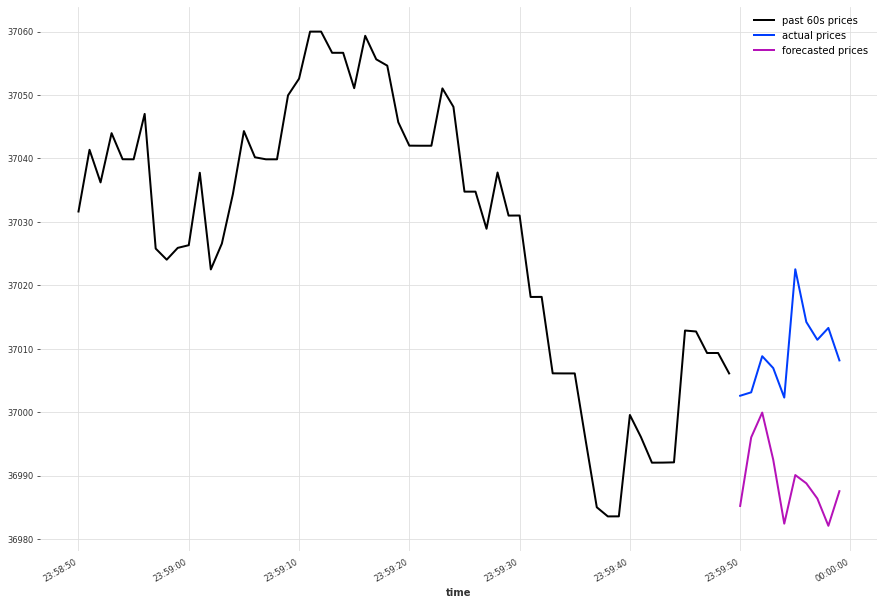

In [40]:
if OOS:
    print('forecasting OOS')
    visualize_forecast(series_ts_tr, series_ts_oos, pred)
else:
    print('forecasting tr-val-te')
    visualize_forecast(series_ts_tr, series_ts_val, pred)

In [41]:
# # Show FORWARD to 2*FORWARD onwards period; expect 越走越迷路
# plt.figure(figsize=(15,10))
# # actual
# series_ts_val[FORWARD:2*FORWARD].plot(label="actual prices")
# # forecast
# pred[FORWARD:2*FORWARD].plot(label="forecasted prices")

In [42]:
def show_losses(loss_logger):
    plt.figure(figsize=(15, 10))
    # skip 1st bc val has an extra one
    plt.plot(loss_logger.train_loss[1:], label="training loss")
    plt.plot(loss_logger.val_loss[1:], label="validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

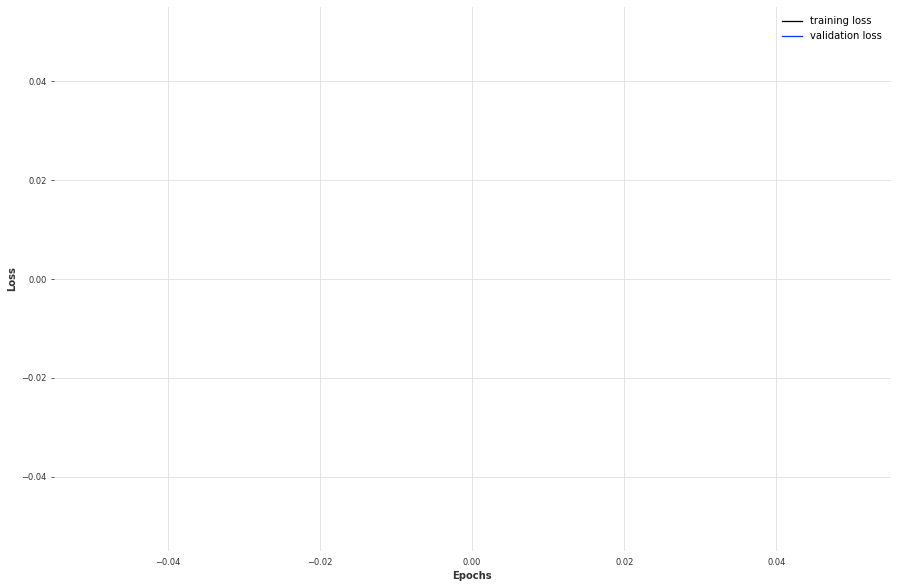

In [43]:
show_losses(loss_logger)

In [44]:
from darts.metrics import *

# These arent plots bc I couldnt find how to integrate it with pytorchLightning so using Darts' function will just get a value
def scores(actual, forecasted):
    """
    should just be of the desired horizon (FORWARD)
        - mae score
        - mape score
        - mse score
        - ope (overall percentage error)
        - r2 score
        - rmse score
    """
    actual = actual[:FORWARD]
    forecasted = forecasted[:FORWARD]

    print("MAE:", np.round(mae(actual, forecasted), 5))
    print("MAPE:", np.round(mape(actual, forecasted), 5), "%")
    print("MSE:", np.round(mse(actual, forecasted), 5))
    print("OPE:", np.round(ope(actual, forecasted), 5), "%")
    print("R2:", np.round(r2_score(actual, forecasted), 5))
    print("RMSE:", np.round(rmse(actual, forecasted), 5))

In [50]:
if OOS:
    scores(series_ts_oos, pred)
else:
    scores(series_ts_val, pred)

MAE: 20.23906
MAPE: 0.05472 %
MSE: 475.8492
OPE: 0.05471 %
R2: -15.04659
RMSE: 21.81397


# Execution Time (nbconvert)

In [46]:
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Execution time:', str(timedelta(seconds=executionTime)))

Execution time in seconds: 72.50480246543884
Execution time: 0:01:12.504802
